### So all other attempts at getting the Ising model to work seemingly are just completely noisy. 
Here, is a careful reimplementation of Schroder's algo. I expect no noise WITH NO AVERAGING at very high temps and very low temps. These should be good keystones to hit along the way

In [144]:
#imports 
import numpy as np
import random
import matplotlib.pyplot as plt

In [145]:
def initLattice(latticeSize: int, hot: bool) -> list[list[int]]:
    lattice = np.zeros((latticeSize, latticeSize))
    if hot:
        for i in range(latticeSize):
            for j in range(latticeSize):
                #pick a random spin
                spin = 0
                randomInt = random.randint(0,1)
                if(randomInt == 1):
                    spin = 1
                else:
                    spin = -1
                #set lattice site equal to the random spin    
                lattice[i][j] = spin
    else: #lattice is cold
        for i in range(latticeSize):
            for j in range(latticeSize):
                #set all lattice sites to spin up
                spin = 1
                lattice[i][j] = spin
    
    return lattice

In [248]:
initLattice(10,False)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [463]:
#It turns out some averaging is actually needed. This demonstrates over 1000 trials of a hot start 10x10 lattice, the expected magnetization is zero
#the expected value of magnetization i.e. the average mag at hot temp is 0, but each individual trial can be up to ~ +- 20
sumArr = []
for inter in range(1000):
    sum = 0
    lat = initLattice(10,True)
    for i in range(10):
        for j in range(10):
            sum += lat[i][j]
    sumArr.append(sum)

np.average(sumArr)


-0.622

In [146]:
# Calculate change in energy of lattice by flipping a single site (i,j)
def deltaU(i: int, j: int, lattice: list) -> float:
    '''
    This calulation requires considering neighboring sites (first term in Hamiltonian)
    Therefore, we will use periodic boundary conditions (torus)
    I would like to imlement the external field term so you can drive the system to specific states

    E1 = -spin(i,j)*sum(spin(neighbors)),     E2 = spin(i,j)*sum(spin(neighbors))
    Ediff = E2 - E1 = 2spin(i,j)*sum(neighbors) (if spin(i,j) is 1 (up))            <<<<< NO epsilon/J? unclear why, currently just implementing pseudocode exactly as written

    In the mean field approximation E_up = -4J*sum(spin(neighbors))/4) 

    i is vertical, j is horizontal, zero indexed
    '''

    size = len(lattice)
    # If site is in an edge, apply periodic boundary conditions
    if(i == 0):
        top = lattice[size-1,j]
    else:
        top = lattice[i-1][j]
    if(i == size-1):
        bottom = lattice[0][j]
    else:
        bottom = lattice[i+1][j]
    if(j == 0):
        left = lattice[i][size-1]
    else:
        left = lattice[i][j-1]
    if(j == size-1):
        right = lattice[i][0]
    else:
        right = lattice[i][j+1]

    #now calculate the energy difference
    Ediff = 2*lattice[i][j]*(top+bottom+left+right)
    return Ediff

In [147]:
def Metropolis(lattice, temp, iterations):
    m = []
    for iteration in range(iterations):

        if((iteration % 100 == 0) and (iteration != 0)):
            sum = 0
            for xSite in range(lattice[0].size):
                for ySite in range(lattice[0].size):
                    sum += lattice[xSite][ySite]
            m.append(abs(sum)) #NEW: try storing abs of mag

        i = random.randint(0,lattice[0].size-1)
        j = random.randint(0,lattice[0].size-1)
        Ediff = deltaU(i,j,lattice)
        #Metropolis to decide whether site should be flipped. Needs to be iterated 100 times??
        if(Ediff <= 0):
            lattice[i][j] = -lattice[i][j] 
        else:
            #now only flip site according to Boltzmann factor
            boltzmannRandom = random.uniform(0,1)
            if(boltzmannRandom < np.exp(-Ediff/temp)): #Ediff must be positive so exponential is between 0 and 1
                lattice[i][j] = -lattice[i][j]

    return m

In [593]:
size = 10
newLattice = initLattice(size,True)
#print(newLattice)
iterationNumber = 100*size*size
Metropolis(newLattice, 2.27, iterationNumber)
#print("\n")
#print(newLattice)


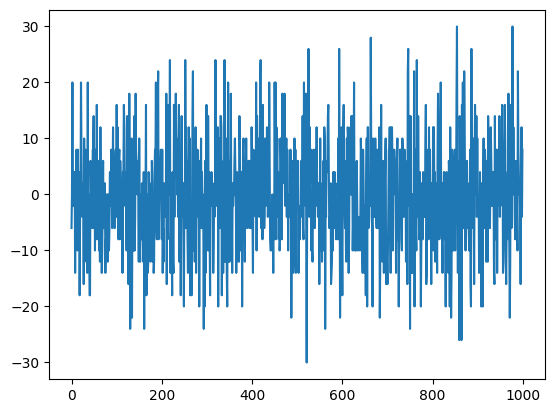

In [861]:
#time series data
sumArr = []
for inter in range(1000):
    sum = 0
    lat = initLattice(10,True)
    for i in range(10):
        for j in range(10):
            sum += lat[i][j]
    sumArr.append(sum)

plt.plot(np.arange(0,len(sumArr)), sumArr)


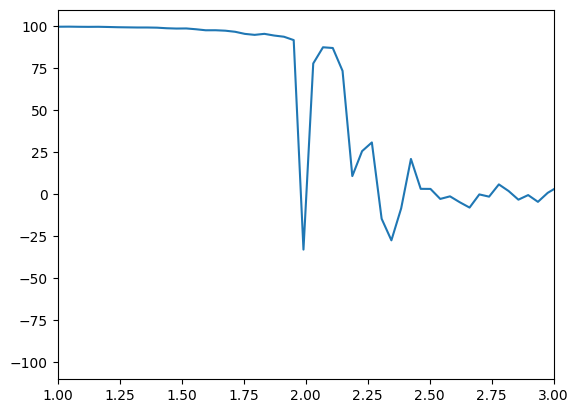

In [1187]:
#reuse averaging code from above with metropolis to make a curve
lat = initLattice(10,False)
avgMags = []
tempRange = np.linspace(0.1,4,100)
for temp in tempRange:
    mTimeSeries = Metropolis(lat, temp, 1000000)
    avg = np.average(mTimeSeries)
    avgMags.append(avg)
    
plt.xlim(1,3)
plt.ylim(-110,110)
plt.plot(tempRange, avgMags) 

Text(0, 0.5, 'Magnetization (100 is max)')

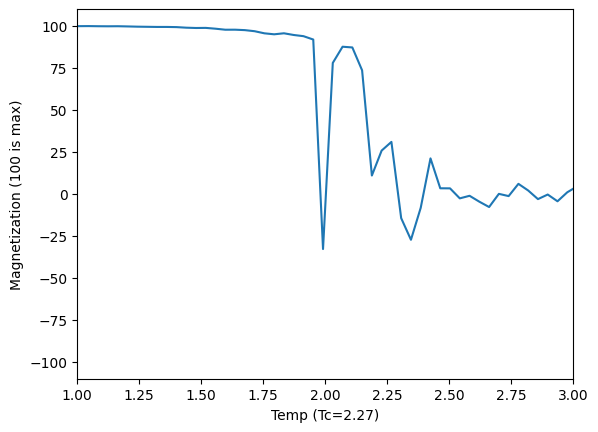

In [1194]:
plt.plot(tempRange, avgMags) 
plt.xlim(1,3)
plt.ylim(-110,110)
plt.xlabel("Temp (Tc=2.27)")
plt.ylabel("Magnetization (100 is max)")
#plt.xlim(0,100)

T = 0.1      1.4%
T = 0.107      1.5%
T = 0.114      1.6%
T = 0.121      1.7%
T = 0.128      1.8%
T = 0.135      1.9%
T = 0.141      2.0%
T = 0.148      2.1%
T = 0.155      2.2%
T = 0.162      2.3%
T = 0.169      2.4%
T = 0.176      2.5%
T = 0.183      2.6%
T = 0.19      2.7%
T = 0.197      2.8%
T = 0.204      2.9%
T = 0.211      3.0%
T = 0.217      3.1%
T = 0.224      3.2%
T = 0.231      3.3%
T = 0.238      3.4%
T = 0.245      3.5%
T = 0.252      3.6%
T = 0.259      3.7%
T = 0.266      3.8%
T = 0.273      3.9%
T = 0.28      4.0%
T = 0.286      4.1%
T = 0.293      4.2%
T = 0.3      4.3%
T = 0.307      4.4%
T = 0.314      4.5%
T = 0.321      4.6%
T = 0.328      4.7%
T = 0.335      4.8%
T = 0.342      4.9%
T = 0.349      5.0%
T = 0.356      5.1%
T = 0.362      5.2%
T = 0.369      5.3%
T = 0.376      5.4%
T = 0.383      5.5%
T = 0.39      5.6%
T = 0.397      5.7%
T = 0.404      5.8%
T = 0.411      5.9%
T = 0.418      6.0%
T = 0.425      6.1%
T = 0.432      6.2%
T = 0.438      6.3%
T = 0.4

Text(0, 0.5, 'Magnetization (100 is max)')

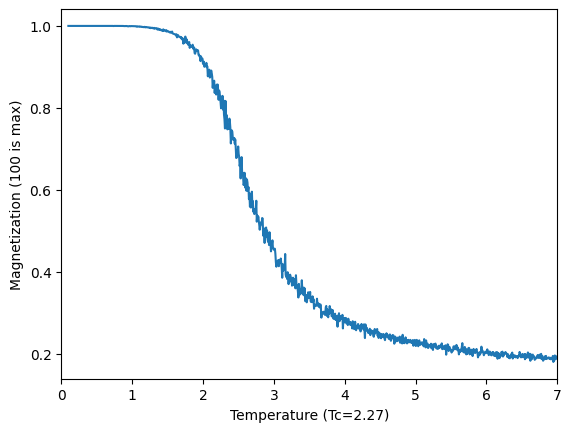

In [148]:
#reuse averaging code from above with metropolis to make a curve
size = 6
lat = initLattice(size,False)
avgMags = []
tempRange = np.linspace(0.1,7,1000)
for temp in tempRange:
    percent = round((temp / 7) * 100, 1)
    print("T = %s      %s%%" % (round(temp,3), percent))
    mTimeSeries = Metropolis(lat, temp, 100000)
    avg = np.average(mTimeSeries)/ (np.power(size,2))
    avgMags.append(avg)
    
plt.xlim(0,7)
#plt.ylim(-110,20*20+10)
plt.plot(tempRange, avgMags) 
plt.xlabel("Temperature (Tc=2.27)")
plt.ylabel("Magnetization (100 is max)")

Text(0, 0.5, 'Magnetization (100 is max)')

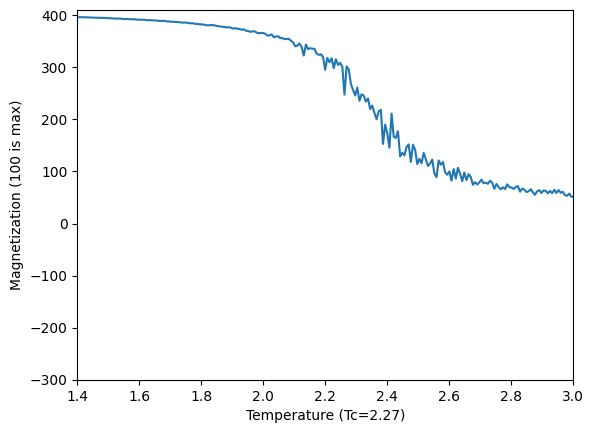

In [1744]:
plt.xlim(1.4,3)
plt.ylim(-300,20*20+10)
plt.plot(tempRange, avgMags) #IDEA: what if i now average over the average magnetization through the critical point so that its smooth? or at least a regression
plt.xlabel("Temperature (Tc=2.27)")
plt.ylabel("Magnetization (100 is max)")

Text(0, 0.5, 'Magnetization (100 is max)')

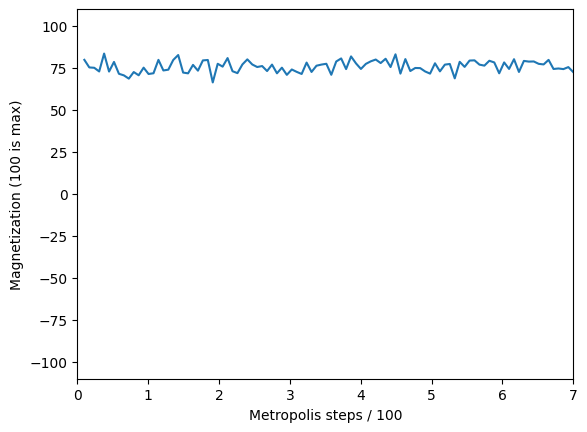

In [1728]:
#reuse averaging code from above with metropolis to make a curve
lat = initLattice(10,True)
avgMags = []
tempRange = np.linspace(0.1,7,100)
for temp in tempRange:
    mTimeSeries = Metropolis(lat, 2.27, 100000)
    avg = np.average(mTimeSeries)
    avgMags.append(avg)
    
plt.xlim(0,7)
plt.ylim(-110,110)
plt.plot(tempRange, avgMags) 
plt.xlabel("Metropolis steps / 100")
plt.ylabel("Magnetization (100 is max)")

some code to gernerate plots for multiple lattice sizes

In [1764]:
#reuse averaging code from above with metropolis to make a curve

avgMags = []

for size in np.arange(6,31,6):
    lat = initLattice(size,False)

    tempRange = np.linspace(0.1,7,1000)
    for temp in tempRange:
        percent = round((temp / 7) * 100, 1)
        print("T = %s      %s%%      s=%s" % (round(temp,3), percent, size))
        mTimeSeries = Metropolis(lat, temp, 1000000)
        avg = np.average(mTimeSeries)/ (np.power(size,2))
        avgMags.append(avg)

T = 0.1      1.4%      s=6
T = 0.107      1.5%      s=6
T = 0.114      1.6%      s=6
T = 0.121      1.7%      s=6
T = 0.128      1.8%      s=6
T = 0.135      1.9%      s=6
T = 0.141      2.0%      s=6
T = 0.148      2.1%      s=6
T = 0.155      2.2%      s=6
T = 0.162      2.3%      s=6
T = 0.169      2.4%      s=6
T = 0.176      2.5%      s=6
T = 0.183      2.6%      s=6
T = 0.19      2.7%      s=6
T = 0.197      2.8%      s=6
T = 0.204      2.9%      s=6
T = 0.211      3.0%      s=6
T = 0.217      3.1%      s=6
T = 0.224      3.2%      s=6
T = 0.231      3.3%      s=6
T = 0.238      3.4%      s=6
T = 0.245      3.5%      s=6
T = 0.252      3.6%      s=6
T = 0.259      3.7%      s=6
T = 0.266      3.8%      s=6
T = 0.273      3.9%      s=6
T = 0.28      4.0%      s=6
T = 0.286      4.1%      s=6
T = 0.293      4.2%      s=6
T = 0.3      4.3%      s=6
T = 0.307      4.4%      s=6
T = 0.314      4.5%      s=6
T = 0.321      4.6%      s=6
T = 0.328      4.7%      s=6
T = 0.335      4.8% 

In [1765]:
threeHourRun = avgMags

In [1780]:
L6 = threeHourRun[0:1000]
L12 = threeHourRun[1000:2000]
L18 = threeHourRun[2000:3000]
L24 = threeHourRun[3000:4000]
L30 = threeHourRun[4000:5000]

Text(0, 0.5, 'Average Magnetization')

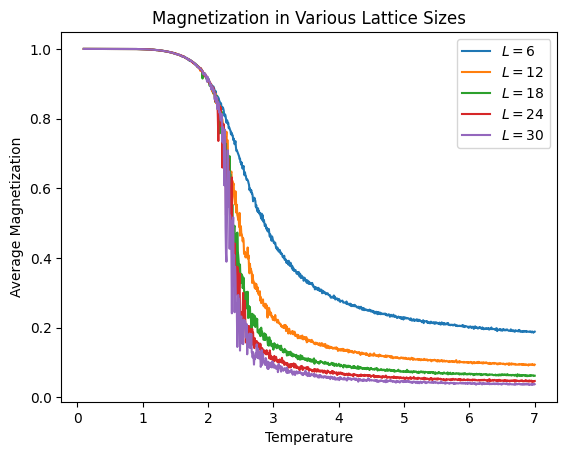

In [1784]:
plt.plot(tempRange, L6, label="$L=6$") 
plt.plot(tempRange, L12, label="$L=12$") 
plt.plot(tempRange, L18, label="$L=18$") 
plt.plot(tempRange, L24, label="$L=24$") 
plt.plot(tempRange, L30, label="$L=30$") 
plt.legend()
plt.title("Magnetization in Various Lattice Sizes")
plt.xlabel("Temperature")
plt.ylabel("Average Magnetization")
#THIS JUST FROM TAKING ABS. I should read binder more and implement Wolff for a cluster algorithm

In [1774]:
import json

with open('ThreeHourMagABS.txt', 'w') as filehandle:
    json.dump(threeHourRun, filehandle)

Following some Binder things.

In [176]:
#define a weird cumulant and determine when the intersect to find critical temperature.
def m24(lattice, temp, iterations):
    m = []
    for iteration in range(iterations):

        if((iteration % 100 == 0) and (iteration != 0)):
            sum = 0
            for xSite in range(lattice[0].size):
                for ySite in range(lattice[0].size):
                    sum += lattice[xSite][ySite]
            m.append(abs(sum)) #NEW: try storing abs of mag

        i = random.randint(0,lattice[0].size-1)
        j = random.randint(0,lattice[0].size-1)
        Ediff = deltaU(i,j,lattice)
        #Metropolis to decide whether site should be flipped. Needs to be iterated 100 times??
        if(Ediff <= 0):
            lattice[i][j] = -lattice[i][j] 
        else:
            #now only flip site according to Boltzmann factor
            boltzmannRandom = random.uniform(0,1)
            if(boltzmannRandom < np.exp(-Ediff/temp)): #Ediff must be positive so exponential is between 0 and 1
                lattice[i][j] = -lattice[i][j]


    return (np.power(m,2), np.power(m,4))

In [177]:
#SIZE = 20
avgm220 = []
avgm420 = []
size = 20
lat = initLattice(size,False)

tempRange = np.linspace(2.1,2.4,1000)
for temp in tempRange:
    percent = round(((temp-2.1) / (2.4-2.1)) * 100, 1)
    print("T = %s      %s%%      s=%s" % (round(temp,3), percent, size))
    m20 = m24(lat, temp, 1000000) #lattice size 20 mags
    m220 = m20[0] #m^2 for lattice size 20
    m420 = m20[1] #m^4 for lattice size 20
    
    #average m^2
    avg220 = np.average(m220)  # get rid of normalization  / (np.power(size,2))
    avgm220.append(avg220) 

    #average m^4
    avg420 = np.average(m420)  # get rid of normalization/ (np.power(size,2))
    avgm420.append(avg420) 

T = 2.1      0.0%      s=20
T = 2.1      0.1%      s=20
T = 2.101      0.2%      s=20
T = 2.101      0.3%      s=20
T = 2.101      0.4%      s=20
T = 2.102      0.5%      s=20
T = 2.102      0.6%      s=20
T = 2.102      0.7%      s=20
T = 2.102      0.8%      s=20
T = 2.103      0.9%      s=20
T = 2.103      1.0%      s=20
T = 2.103      1.1%      s=20
T = 2.104      1.2%      s=20
T = 2.104      1.3%      s=20
T = 2.104      1.4%      s=20
T = 2.105      1.5%      s=20
T = 2.105      1.6%      s=20
T = 2.105      1.7%      s=20
T = 2.105      1.8%      s=20
T = 2.106      1.9%      s=20
T = 2.106      2.0%      s=20
T = 2.106      2.1%      s=20
T = 2.107      2.2%      s=20
T = 2.107      2.3%      s=20
T = 2.107      2.4%      s=20
T = 2.108      2.5%      s=20
T = 2.108      2.6%      s=20
T = 2.108      2.7%      s=20
T = 2.108      2.8%      s=20
T = 2.109      2.9%      s=20
T = 2.109      3.0%      s=20
T = 2.109      3.1%      s=20
T = 2.11      3.2%      s=20
T = 2.11      3

In [178]:
#SIZE = 10
avgm210 = []
avgm410 = []
size = 10
lat = initLattice(size,False)

tempRange = np.linspace(2.1,2.4,1000)
for temp in tempRange:
    percent = round(((temp-2.1) / (2.4-2.1)) * 100, 1)
    print("T = %s      %s%%      s=%s" % (round(temp,3), percent, size))
    m10 = m24(lat, temp, 1000000) #lattice size 20 mags
    m210 = m10[0] #m^2 for lattice size 20
    m410 = m10[1] #m^4 for lattice size 20
    
    #average m^2
    avg210 = np.average(m210)  # get rid of normalization  / (np.power(size,2)) / (np.power(size,2))
    avgm210.append(avg210) 

    #average m^4
    avg410 = np.average(m410)  # get rid of normalization  / (np.power(size,2))/ (np.power(size,2))
    avgm410.append(avg410)

T = 2.1      0.0%      s=10
T = 2.1      0.1%      s=10
T = 2.101      0.2%      s=10
T = 2.101      0.3%      s=10
T = 2.101      0.4%      s=10
T = 2.102      0.5%      s=10
T = 2.102      0.6%      s=10
T = 2.102      0.7%      s=10
T = 2.102      0.8%      s=10
T = 2.103      0.9%      s=10
T = 2.103      1.0%      s=10
T = 2.103      1.1%      s=10
T = 2.104      1.2%      s=10
T = 2.104      1.3%      s=10
T = 2.104      1.4%      s=10
T = 2.105      1.5%      s=10
T = 2.105      1.6%      s=10
T = 2.105      1.7%      s=10
T = 2.105      1.8%      s=10
T = 2.106      1.9%      s=10
T = 2.106      2.0%      s=10
T = 2.106      2.1%      s=10
T = 2.107      2.2%      s=10
T = 2.107      2.3%      s=10
T = 2.107      2.4%      s=10
T = 2.108      2.5%      s=10
T = 2.108      2.6%      s=10
T = 2.108      2.7%      s=10
T = 2.108      2.8%      s=10
T = 2.109      2.9%      s=10
T = 2.109      3.0%      s=10
T = 2.109      3.1%      s=10
T = 2.11      3.2%      s=10
T = 2.11      3

In [179]:
div10 = []
for i in range(len(avgm210)):
    div10.append(1 - (avgm410[i]) / (3*np.power(avgm210[i],2)) )

In [180]:
div20 = []
for i in range(len(avgm220)):
    div20.append(1 - (avgm420[i]) / (3*np.power(avgm220[i],2)) )

### Make susceptibility plots once this is done NO MATTER WHAT

(2.0, 2.5)

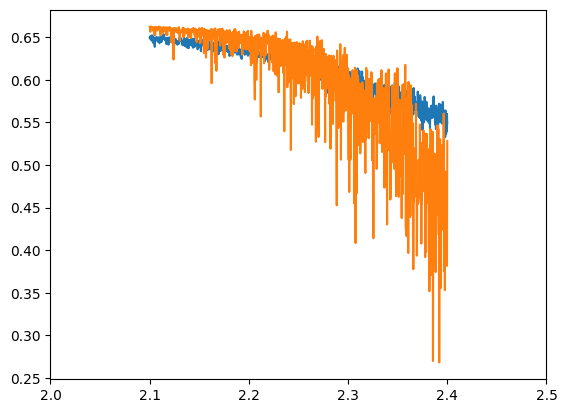

In [181]:
plt.plot(tempRange, div10)
plt.plot(tempRange, div20)
plt.xlim(2,2.5)

In [27]:
import json

with open('Ul20.txt', 'w') as filehandle:
    json.dump(div20, filehandle)

In [10]:
def MetCor(lattice, temp, iterations):
    corArr = []
    prodArr = []
    s1Arr = []
    s2Arr = []
    for iteration in range(iterations):

        if((iteration % 100 == 0) and (iteration != 0)):
            i1 = 1
            j1 = 1
            i2 = size-1
            j2 = size-1

            #measure and store product of lattice sites
            prod = lattice[i1][j1] * lattice[i2][j2]
            prodArr.append(prod) 

            #measure and store each spin state
            s1Arr.append(lattice[i1][j1])
            s2Arr.append(lattice[i2][j2])

        i = random.randint(0,lattice[0].size-1)
        j = random.randint(0,lattice[0].size-1)
        Ediff = deltaU(i,j,lattice)
        #Metropolis to decide whether site should be flipped. Needs to be iterated 100 times??
        if(Ediff <= 0):
            lattice[i][j] = -lattice[i][j] 
        else:
            #now only flip site according to Boltzmann factor
            boltzmannRandom = random.uniform(0,1)
            if(boltzmannRandom < np.exp(-Ediff/temp)): #Ediff must be positive so exponential is between 0 and 1
                lattice[i][j] = -lattice[i][j]

    #now calculate correlation and store it
    avgProd = np.average(prodArr)
    avgS1 = np.average(s1Arr)
    avgS2 = np.average(s2Arr)

    cor = avgProd - (avgS1)*(avgS2)

    return cor

T = 0.1      1.4%
T = 0.107      1.5%
T = 0.114      1.6%
T = 0.121      1.7%
T = 0.128      1.8%
T = 0.135      1.9%
T = 0.141      2.0%
T = 0.148      2.1%
T = 0.155      2.2%
T = 0.162      2.3%
T = 0.169      2.4%
T = 0.176      2.5%
T = 0.183      2.6%
T = 0.19      2.7%
T = 0.197      2.8%
T = 0.204      2.9%
T = 0.211      3.0%
T = 0.217      3.1%
T = 0.224      3.2%
T = 0.231      3.3%
T = 0.238      3.4%
T = 0.245      3.5%
T = 0.252      3.6%
T = 0.259      3.7%
T = 0.266      3.8%
T = 0.273      3.9%
T = 0.28      4.0%
T = 0.286      4.1%
T = 0.293      4.2%
T = 0.3      4.3%
T = 0.307      4.4%
T = 0.314      4.5%
T = 0.321      4.6%
T = 0.328      4.7%
T = 0.335      4.8%
T = 0.342      4.9%
T = 0.349      5.0%
T = 0.356      5.1%
T = 0.362      5.2%
T = 0.369      5.3%
T = 0.376      5.4%
T = 0.383      5.5%
T = 0.39      5.6%
T = 0.397      5.7%
T = 0.404      5.8%
T = 0.411      5.9%
T = 0.418      6.0%
T = 0.425      6.1%
T = 0.432      6.2%
T = 0.438      6.3%
T = 0.4

Text(0, 0.5, 'Correlation')

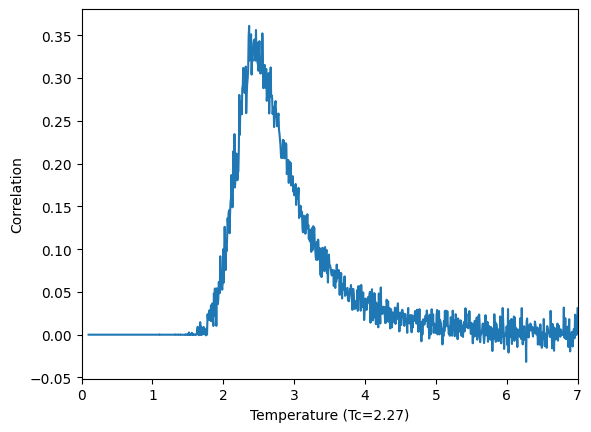

In [122]:
#reuse averaging code from above with metropolis to make a curve
size = 6
lat = initLattice(size,False)
avgCor = []
tempRange = np.linspace(0.1,7,1000)
for temp in tempRange:
    percent = round((temp / 7) * 100, 1)
    print("T = %s      %s%%" % (round(temp,3), percent))
    averaging = []
    for i in range(100):
        corTimeSeries = MetCor(lat, temp, 10000)
        averaging.append(corTimeSeries)
    avgCor.append(np.average(averaging))
    
plt.xlim(0,7)
#plt.ylim(-110,20*20+10)
plt.plot(tempRange, avgCor) 
plt.xlabel("Temperature (Tc=2.27)")
plt.ylabel("Correlation")

In [118]:
for i in range(10):
    corTimeSeries = MetCor(lat, 100, 10000)
    averaging.append(corTimeSeries)
avgCor = np.average(averaging)

print(avgCor)


-0.01793762427931951


In [123]:
#do cumulation calclation next

Susceptibility Calc: $\chi = N\beta \left( \langle m^2 \rangle - \langle m \rangle^2 \right)$ where $\beta \equiv \frac{1}{kT}$ and $N$ is the number of sites.

In [159]:
def MetSus(lattice, temp, iterations):
    m = []
    for iteration in range(iterations):

        if((iteration % 100 == 0) and (iteration != 0)):
            sum = 0
            for xSite in range(lattice[0].size):
                for ySite in range(lattice[0].size):
                    sum += lattice[xSite][ySite]
            m.append(abs(sum)) #NEW: try storing abs of mag

        i = random.randint(0,lattice[0].size-1)
        j = random.randint(0,lattice[0].size-1)
        Ediff = deltaU(i,j,lattice)
        #Metropolis to decide whether site should be flipped. Needs to be iterated 100 times??
        if(Ediff <= 0):
            lattice[i][j] = -lattice[i][j] 
        else:
            #now only flip site according to Boltzmann factor
            boltzmannRandom = random.uniform(0,1)
            if(boltzmannRandom < np.exp(-Ediff/temp)): #Ediff must be positive so exponential is between 0 and 1
                lattice[i][j] = -lattice[i][j]

    return (m, np.power(m,2))

T = 0.1      1.4%
T = 0.107      1.5%
T = 0.114      1.6%
T = 0.121      1.7%
T = 0.128      1.8%
T = 0.135      1.9%
T = 0.141      2.0%
T = 0.148      2.1%
T = 0.155      2.2%
T = 0.162      2.3%
T = 0.169      2.4%
T = 0.176      2.5%
T = 0.183      2.6%
T = 0.19      2.7%
T = 0.197      2.8%
T = 0.204      2.9%
T = 0.211      3.0%
T = 0.217      3.1%
T = 0.224      3.2%
T = 0.231      3.3%
T = 0.238      3.4%
T = 0.245      3.5%
T = 0.252      3.6%
T = 0.259      3.7%
T = 0.266      3.8%
T = 0.273      3.9%
T = 0.28      4.0%
T = 0.286      4.1%
T = 0.293      4.2%
T = 0.3      4.3%
T = 0.307      4.4%
T = 0.314      4.5%
T = 0.321      4.6%
T = 0.328      4.7%
T = 0.335      4.8%
T = 0.342      4.9%
T = 0.349      5.0%
T = 0.356      5.1%
T = 0.362      5.2%
T = 0.369      5.3%
T = 0.376      5.4%
T = 0.383      5.5%
T = 0.39      5.6%
T = 0.397      5.7%
T = 0.404      5.8%
T = 0.411      5.9%
T = 0.418      6.0%
T = 0.425      6.1%
T = 0.432      6.2%
T = 0.438      6.3%
T = 0.4

Text(0, 0.5, 'Magnetization (100 is max)')

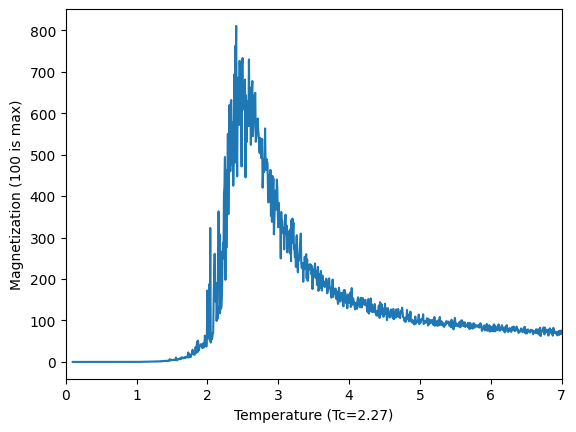

In [168]:
#reuse averaging code from above with metropolis to make a curve
size = 10 
lat = initLattice(size,False)
avgSus10 = []
tempRange = np.linspace(0.1,7,1000)
for temp in tempRange:
    percent = round((temp / 7) * 100, 1)
    print("T = %s      %s%%" % (round(temp,3), percent))
    TimeSeries = MetSus(lat, temp, 100000)
    avgM = np.average(TimeSeries[0])
    avgMSquared = np.power(avgM,2)
    avgSquaredM = np.average(TimeSeries[1])
    sus = avgSquaredM - avgMSquared
    avgSus10.append(sus)
    
plt.xlim(0,7)
#plt.ylim(-110,20*20+10)
plt.plot(tempRange, avgSus10) 
plt.xlabel("Temperature (Tc=2.27)")
plt.ylabel("Magnetization (100 is max)")

T = 0.1      1.4%
T = 0.107      1.5%
T = 0.114      1.6%
T = 0.121      1.7%
T = 0.128      1.8%
T = 0.135      1.9%
T = 0.141      2.0%
T = 0.148      2.1%
T = 0.155      2.2%
T = 0.162      2.3%
T = 0.169      2.4%
T = 0.176      2.5%
T = 0.183      2.6%
T = 0.19      2.7%
T = 0.197      2.8%
T = 0.204      2.9%
T = 0.211      3.0%
T = 0.217      3.1%
T = 0.224      3.2%
T = 0.231      3.3%
T = 0.238      3.4%
T = 0.245      3.5%
T = 0.252      3.6%
T = 0.259      3.7%
T = 0.266      3.8%
T = 0.273      3.9%
T = 0.28      4.0%
T = 0.286      4.1%
T = 0.293      4.2%
T = 0.3      4.3%
T = 0.307      4.4%
T = 0.314      4.5%
T = 0.321      4.6%
T = 0.328      4.7%
T = 0.335      4.8%
T = 0.342      4.9%
T = 0.349      5.0%
T = 0.356      5.1%
T = 0.362      5.2%
T = 0.369      5.3%
T = 0.376      5.4%
T = 0.383      5.5%
T = 0.39      5.6%
T = 0.397      5.7%
T = 0.404      5.8%
T = 0.411      5.9%
T = 0.418      6.0%
T = 0.425      6.1%
T = 0.432      6.2%
T = 0.438      6.3%
T = 0.4

Text(0, 0.5, 'Magnetization (100 is max)')

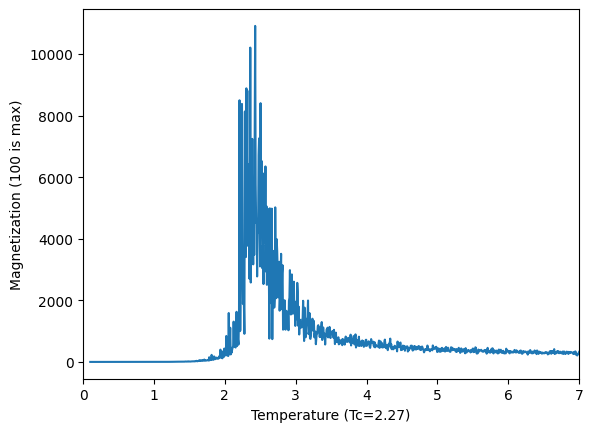

In [167]:
#reuse averaging code from above with metropolis to make a curve
size = 20 
lat = initLattice(size,False)
avgSus20 = []
tempRange = np.linspace(0.1,7,1000)
for temp in tempRange:
    percent = round((temp / 7) * 100, 1)
    print("T = %s      %s%%" % (round(temp,3), percent))
    TimeSeries = MetSus(lat, temp, 100000)
    avgM = np.average(TimeSeries[0])
    avgMSquared = np.power(avgM,2)
    avgSquaredM = np.average(TimeSeries[1])
    sus = avgSquaredM - avgMSquared
    avgSus20.append(sus)
    
plt.xlim(0,7)
#plt.ylim(-110,20*20+10)
plt.plot(tempRange, avgSus20) 
plt.xlabel("Temperature (Tc=2.27)")
plt.ylabel("Magnetization (100 is max)")

<>:8: SyntaxWarning: invalid escape sequence '\c'
<>:8: SyntaxWarning: invalid escape sequence '\c'
/var/folders/tf/m_q5jhc978j5bnsvc9p4163h0000gn/T/ipykernel_19100/1415078815.py:8: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("$\chi$")


Text(0, 0.5, '$\\chi$')

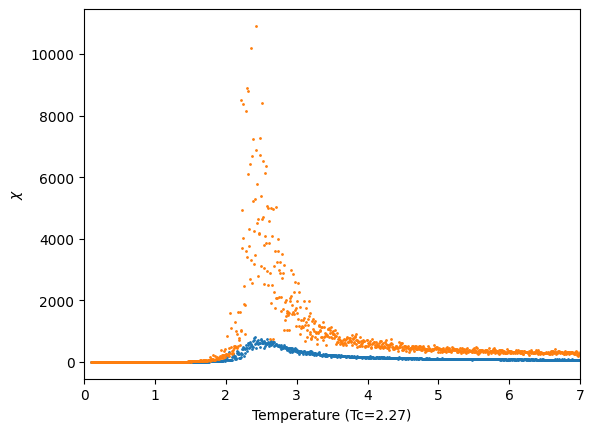

In [175]:
import copy

plt.xlim(0,7)
#plt.ylim(-110,20*20+10)
plt.scatter(tempRange, avgSus10, s=1) 
plt.scatter(tempRange, avgSus20, s=1)
plt.xlabel("Temperature (Tc=2.27)")
plt.ylabel("$\chi$")